In [1]:
from fktools import *

import tensorflow as tf

from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CDKMRippleCarryAdder, ModularAdderGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino

import networkx as nx

import math

/Users/filip/Sync/qw-defects/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


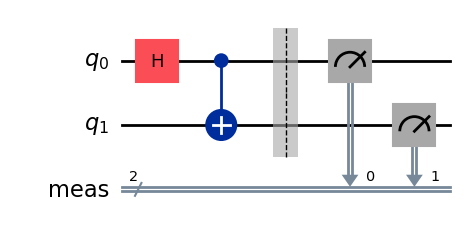

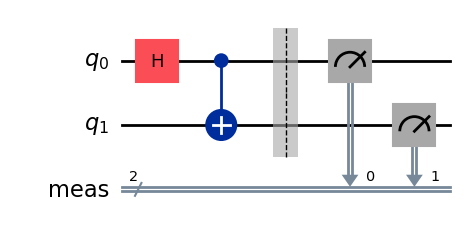

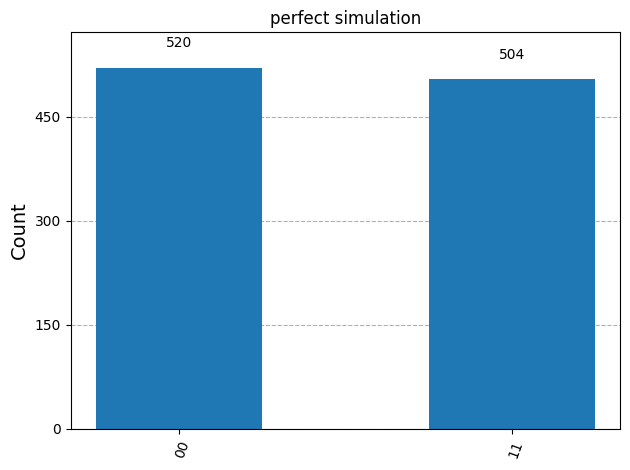

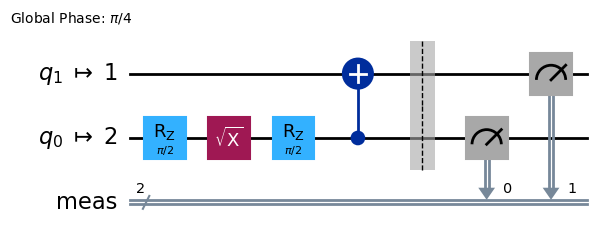

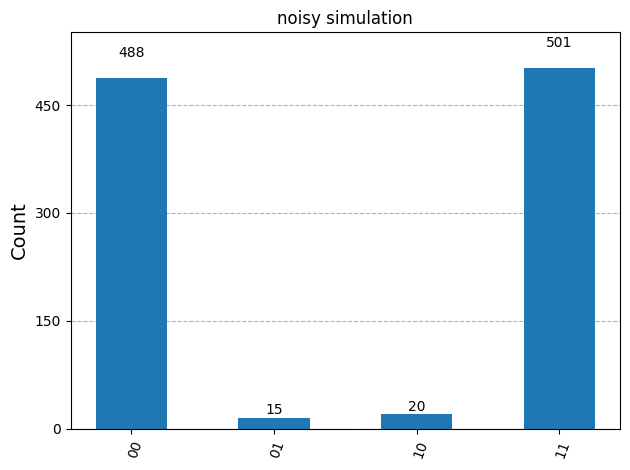

In [2]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

display(circ.draw('mpl'))


sim_ideal = AerSimulator()

tcirc = transpile(circ, sim_ideal)

result = sim_ideal.run(tcirc).result()
counts = result.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts, title="perfect simulation"))



device_backend = FakeVigoV2()
sim_vigo = AerSimulator.from_backend(device_backend)

tcirc = transpile(circ, sim_vigo)

result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts_noise, title="noisy simulation"))


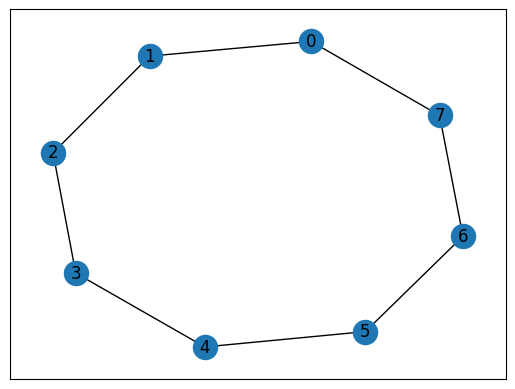

In [3]:
nodes = 2**3

G = nx.Graph()

G.add_nodes_from(np.arange(nodes).tolist())
G.add_edges_from([(i, (i+1)%nodes) for i in range(nodes)])
nx.draw_networkx(G)

In [91]:
class walk_circuit:
    def __init__(self, nodes_power, num_steps):
        self.nodes_power = nodes_power
        self.num_steps = num_steps

    def build(self) -> QuantumCircuit:
        q_pos = QuantumRegister(self.nodes_power, "q_pos")
        q_one = QuantumRegister(self.nodes_power, "q_one")  
        q_coin = QuantumRegister(1, "q_coin") 
        c_pos = ClassicalRegister(self.nodes_power, "c_pos")
        regs = [q_one, q_pos, q_coin, c_pos]


        ControlledModularAdder = ModularAdderGate(num_state_qubits=self.nodes_power).control(num_ctrl_qubits=1)

        qc = QuantumCircuit(*regs)

        qc.x(q_one[0])


        for _ in range(self.num_steps):

            qc.h(q_coin)

            qc.append(ControlledModularAdder, [q_coin, *q_one, *q_pos])

            qc.x(q_coin)
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one, *q_pos])
            qc.x(q_coin)


        qc.measure(q_pos, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

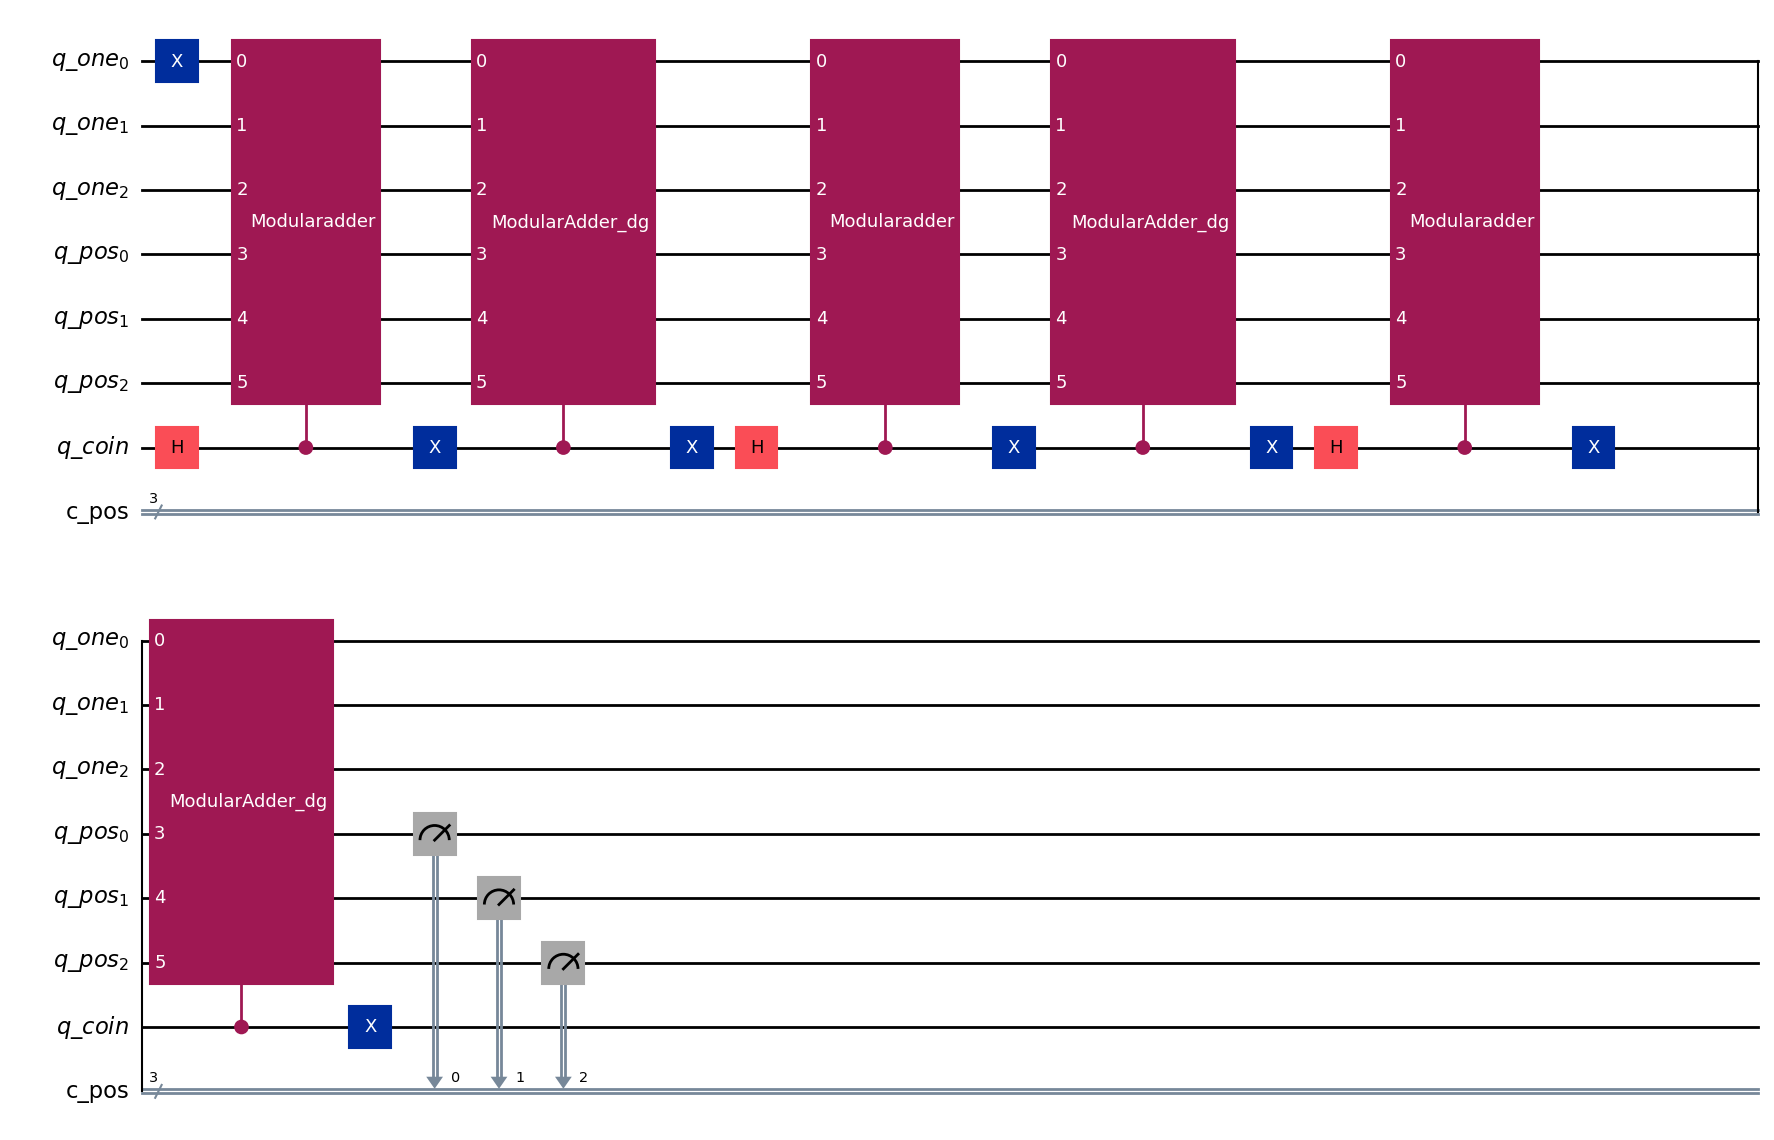

15


In [5]:
wc = walk_circuit(3, 3)
qc = wc.build()
display(qc.draw('mpl'))
print(qc.depth())

<BarContainer object of 8 artists>

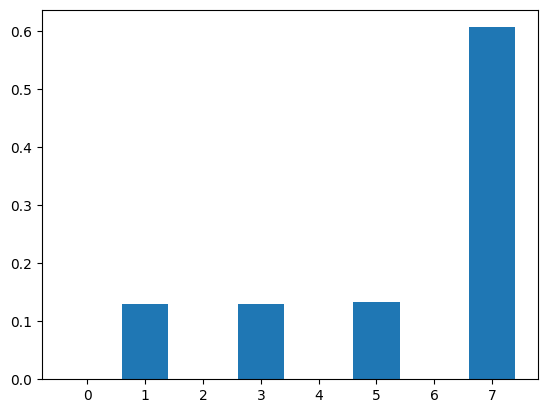

In [6]:
plt.bar(np.arange(2**wc.nodes_power), wc.run())

<BarContainer object of 8 artists>

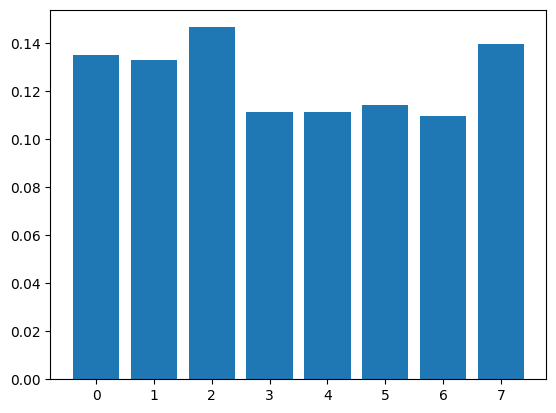

In [7]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=FakeTorino()))

In [8]:
steps = 4
power = 3
propagation = np.zeros(shape=(steps, 2**power))

for step in range(steps):
    wc = walk_circuit(power, step)
    qc = wc.build()
    propagation[step] = wc.run(simulator=FakeTorino())

plt.imshow(propagation, cmap='turbo')

KeyboardInterrupt: 

In [ ]:
class walk_circuit_times3:
    def __init__(self, nodes_power, num_steps):
        self.nodes_power = nodes_power
        self.num_steps = num_steps

    def build(self) -> QuantumCircuit:
        q_pos1 = QuantumRegister(self.nodes_power, "q_pos1")
        q_pos2 = QuantumRegister(self.nodes_power, "q_pos2")
        q_pos3 = QuantumRegister(self.nodes_power, "q_pos3")
        q_one1 = QuantumRegister(self.nodes_power, "q_one1")
        q_one2 = QuantumRegister(self.nodes_power, "q_one2")
        q_one3 = QuantumRegister(self.nodes_power, "q_one3")
        q_coin = QuantumRegister(1, "q_coin")
        q_res = QuantumRegister(self.nodes_power, "q_res")
        c_pos = ClassicalRegister(self.nodes_power, "c_pos1")
        regs = [q_one1,q_pos1, q_one2,q_pos2 ,q_one3,q_pos3, q_coin, q_res, c_pos]


        ControlledModularAdder = ModularAdderGate(num_state_qubits=self.nodes_power).control(num_ctrl_qubits=1)

        qc = QuantumCircuit(*regs)

        qc.x(q_one1[0])
        qc.x(q_one2[0])
        qc.x(q_one3[0])


        for _ in range(self.num_steps):

            qc.h(q_coin)

            qc.append(ControlledModularAdder, [q_coin, *q_one1, *q_pos1])
            qc.append(ControlledModularAdder, [q_coin, *q_one2, *q_pos2])
            qc.append(ControlledModularAdder, [q_coin, *q_one3, *q_pos3])

            qc.x(q_coin)
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one1, *q_pos1])
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one2, *q_pos2])
            qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one3, *q_pos3])
            qc.x(q_coin)


        for i in range(self.nodes_power):
            qc.mcx([q_pos1[i], q_pos2[i]], q_res[i])
            qc.mcx([q_pos2[i], q_pos3[i]], q_res[i])
            qc.mcx([q_pos1[i], q_pos3[i]], q_res[i])

        qc.measure(q_res, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

In [20]:
# wct = walk_circuit_test(2, 1)
# qct = wct.build()

wc = walk_circuit(2, 2)
qc = wc.build()

# display(qct.draw('mpl'))
# print(qct.depth())

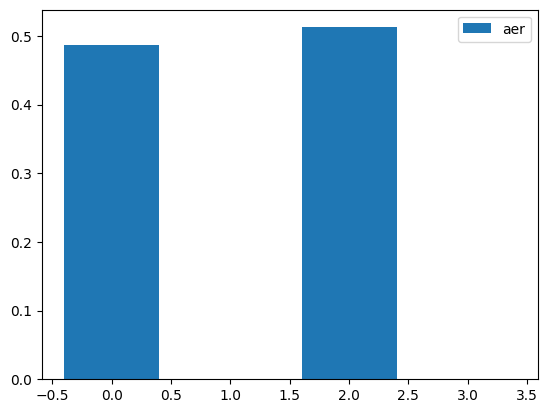

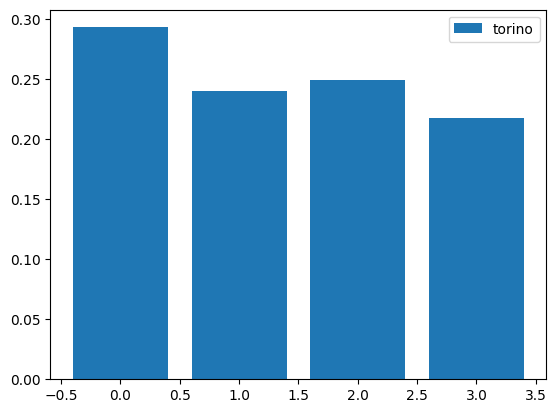

In [21]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=AerSimulator()), label="aer")
plt.legend()
plt.show()
plt.bar(np.arange(2**wc.nodes_power), wc.run(simulator=FakeTorino()), label="torino")
plt.legend()
plt.show()

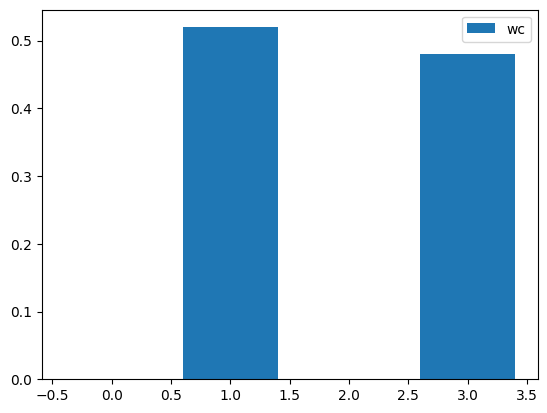

In [16]:
plt.bar(np.arange(2**wc.nodes_power), wc.run(), label="wc")
plt.legend()
plt.show()

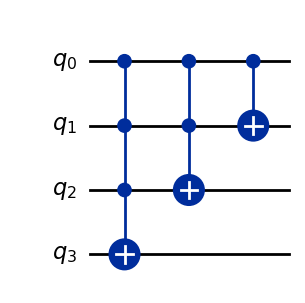

96

In [42]:
at3 = QuantumCircuit(4)

at3.mcx([0, 1, 2], 3)
at3.mcx([0, 1], 2)
at3.mcx([0], 1)

display(at3.draw('mpl'))


qc.measure_all()




simulator = AerSimulator()
tqc = transpile(qc, simulator)




result = simulator.run(tqc).result()
counts = result.get_counts(0)
plot_histogram(counts)
tqc.depth()

In [80]:
def control_add_one(position_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(position_qubits + 1, name='control_add_one')

    for i in range(position_qubits, 0, -1):
        qc.mcx([j for j in range(i)], i)
    
    return qc

class walk_circuit_simpler:
    def __init__(self, nodes_power, num_steps):
        self.nodes_power = nodes_power
        self.num_steps = num_steps

    def build(self) -> QuantumCircuit:
        q_pos = QuantumRegister(self.nodes_power, "q_pos")
        q_coin = QuantumRegister(1, "q_coin")
        c_pos = ClassicalRegister(self.nodes_power, "c_pos")
        regs = [q_pos, q_coin, c_pos]

        qc = QuantumCircuit(*regs)

        for _ in range(self.num_steps):

            qc.h(q_coin)

            qc.append(control_add_one(self.nodes_power), [q_coin, *q_pos])
            

            qc.x(q_coin)
            qc.x(q_pos)
            qc.append(control_add_one(self.nodes_power), [q_coin, *q_pos])
            qc.x(q_coin)
            qc.x(q_pos)


        qc.measure(q_pos, c_pos)

        self.qc = qc

        return qc
    
    def run(self, simulator = AerSimulator(), shots = 1024):

        tcirc = transpile(self.qc, simulator)

        result = simulator.run(tcirc, shots=shots).result()
        counts = result.get_counts(0)

        probs = np.zeros(shape=(2**self.nodes_power), dtype=np.float32)

        for key in counts.keys():
            probs[int(key, 2)] = counts[key]
        probs /= np.sum(probs)

        return probs

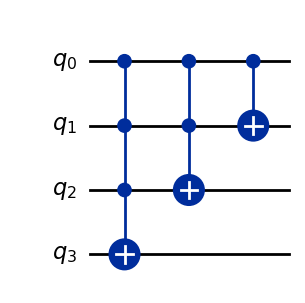

In [81]:
control_add_one(3).draw('mpl')

1 3 63
2 59 1405
3 187 2532
4 653 3684
5 1444 4885
6 2564 5987
7 3985 7125
8 5642 8619
9 8051 9878
10 10688 11098
11 13697 12327
12 17363 13689
13 20710 14821
14 24986 15598
15 29279 17059
16 34843 18754
17 39918 19685
18 46333 21146
19 50877 22201


Text(0.5, 1.0, 'transpiled circuit depth for FakeTorino')

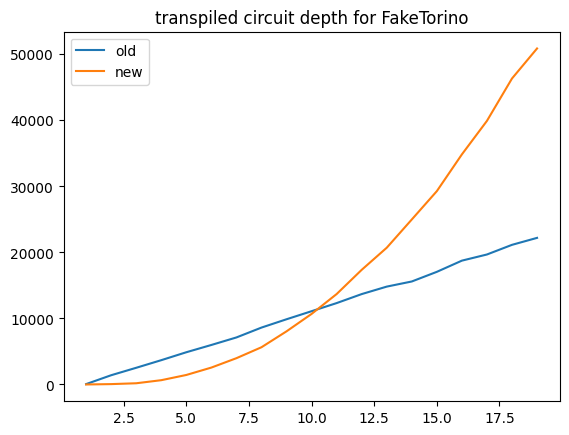

In [99]:
wcd = []
wcsd = []

for i in range(1, 20):
    wc = walk_circuit(i, 1)
    wcs = walk_circuit_simpler(i, 1)

    qc = wc.build()
    qc = transpile(qc, FakeTorino())

    qcs = wcs.build()
    qcs = transpile(qcs, FakeTorino())


    print(i, qcs.depth(), qc.depth())
    wcd.append(qc.depth())
    wcsd.append(qcs.depth())


plt.plot(np.arange(1, len(wcd)+1), wcd, label="old")
plt.plot(np.arange(1, len(wcsd)+1), wcsd, label="new")
plt.legend()
plt.title("transpiled circuit depth for FakeTorino")
# plt.bar(np.arange(2**wcs.nodes_power), wcs.run(simulator=FakeTorino()), label="wcs")
# plt.show()
# plt.bar(np.arange(2**wcs.nodes_power), wcs.run(simulator=AerSimulator()), label="wcs")